# Introduction

This notebook contains code to run 4 topic models using Amazon review sample data. For each model we intend to compare keywords outputed from models with default parameters or tuned numbers of topics. We also report model performance using coherence scores if applicables. The four models included 1) LDA, 2) NMF, 3) Top2Vec, and 4) BERTopic

In [1]:
# !pip install pyLDAvis
# !pip install top2vec[sentence_encoders]
# !pip install top2vec[sentence_transformers]
# !pip install top2vec[indexing]
# !pip install top2vec
# !pip install tensorflow tensorflow_hub tensorflow_text

In [5]:
import logging
import spacy
import warnings

# Set the logging level to suppress warnings
logging.getLogger("spacy").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", message="distutils Version classes are deprecated.*")
logging.basicConfig(level=logging.WARNING)

# Create a custom filter class to exclude log messages containing 'top2vec - INFO'
class CustomFilter(logging.Filter):
    def filter(self, record):
        return not record.getMessage().startswith('top2vec - INFO') or not record.getMessage().startswith('DeprecationWarning')

# Configure the root logger with the custom filter
logging.basicConfig(level=logging.INFO)
logging.getLogger().addFilter(CustomFilter())

In [11]:
# Set the logging level for the 'top2vec' module to suppress 'INFO' level log messages
logging.getLogger('top2vec').disabled = True

In [25]:
# Set the logging level for the 'BERTopic' module to suppress log messages
logging.getLogger('BERTopic').disabled = True

In [57]:
logging.getLogger('gensim.models.ldamodel').setLevel(logging.ERROR)

In [7]:
# read data
import pandas as pd
import gzip
import json
import pickle
from string import punctuation
import re
import seaborn as sns
import numpy as np
import os
import random
# preprocessing
import spacy
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer
from spacy.lang.char_classes import ALPHA, ALPHA_LOWER, ALPHA_UPPER, CONCAT_QUOTES, LIST_ELLIPSES, LIST_ICONS
from spacy.util import compile_infix_regex
from operator import itemgetter

# modeling
import gensim.corpora as corpora
import gensim
from pprint import pprint
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from gensim.models import Nmf
from gensim.corpora.dictionary import Dictionary
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
from top2vec import Top2Vec
from bertopic import BERTopic
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN

# 0: Load review data

In [ ]:
url = 'C://Users//KristinChen//Downloads//Pet_Supplies_5.json.gz' #data is downloaded from here: https://nijianmo.github.io/amazon/index.html

    
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(url)

In [ ]:
df.drop_duplicates(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary']).shape #1,974,009

In [ ]:
cleaned_df = df.drop_duplicates(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary']).dropna(subset = 'reviewText').reset_index(drop = True)

cleaned_df = cleaned_df[~cleaned_df['reviewText'].apply(lambda x: 'div id' in x)].reset_index(drop = True)

# 0: Load metadata

In [ ]:
i = 0
data = {}
with gzip.open('All_Amazon_Meta.json.gz') as f:
    for l in f:
        obj = json.loads(l.strip())
        try: 
            data[obj['asin']] = obj['category']
            if len(data) % 10000 == 0:
                i += 1
                print(i, len(data))
                with open('metadata_batch{}.pickle'.format(i), 'wb') as handle:
                    pickle.dump(data, handle)
                data = {}
        except IndexError: 
            print(obj['category'])

In [ ]:
tot_metadata_dict = {}
for file in os.listdir('.'):
    if file.startswith('metadata_batch'):
        print(file)
        with open(file, 'rb') as handle:
            data = pickle.load(handle)
            tot_metadata_dict.update(data)
            print(len(tot_metadata_dict))

In [ ]:
len(tot_metadata_dict) #13,491,466

In [ ]:
with open('tot_metadata_{}.pickle'.format(len(tot_metadata_dict)), 'wb') as handle:
    pickle.dump(tot_metadata_dict, handle)

In [ ]:
with open('tot_metadata_14737765.pickle', 'rb') as handle:
    tot_metadata_dict = pickle.load(handle)

In [ ]:
%%time
# merge product categories to review data
cleaned_df['categories'] = cleaned_df['asin'].apply(lambda x: tot_metadata_dict.get(str(x), []))

In [ ]:
sub_cleaned_df =  cleaned_df.dropna(subset = 'categories')

In [ ]:
sub_cleaned_df['categories'] = sub_cleaned_df['categories'].apply(lambda x: x[1:])
sub_cleaned_df['categories2'] = sub_cleaned_df['categories'].apply(lambda x: '->'.join(x) if len(x) > 0 else x)
x = pd.DataFrame(sub_cleaned_df['categories'].tolist()).reset_index(drop = True)
sub_cleaned_df2 = pd.concat([sub_cleaned_df, x], axis = 1)

# 0: Get sample data

In [ ]:
lst = ['Dogs', 'Cats']
sub_cleaned_df3 = sub_cleaned_df2[sub_cleaned_df2[0].isin(lst)].reset_index(drop = True)
sub_cleaned_df3 = sub_cleaned_df3.rename({0: 'category_level1', 
                                            1: 'category_level2',
                                            2: 'category_level3',
                                            3: 'category_level4',
                                            4: 'category_level5',
                                            5: 'category_level6',
                                            6: 'category_level7'}, axis = 1)
sub_cleaned_df3 = sub_cleaned_df3.dropna(subset = 'category_level2').reset_index(drop = True)

In [ ]:
sub_cleaned_df3['category_level2'] = sub_cleaned_df3['category_level2'].apply(lambda x: re.sub('&amp;', '&', x) if isinstance(x, str) else x)
sub_cleaned_df3['category_level3'] = sub_cleaned_df3['category_level3'].apply(lambda x: re.sub('&amp;', '&', x) if isinstance(x, str) else x)
sub_cleaned_df3['category_level4'] = sub_cleaned_df3['category_level4'].apply(lambda x: re.sub('&amp;', '&', x) if isinstance(x, str) else x)
sub_cleaned_df3['category_level5'] = sub_cleaned_df3['category_level5'].apply(lambda x: re.sub('&amp;', '&', x) if isinstance(x, str) else x)
sub_cleaned_df3['category_level6'] = sub_cleaned_df3['category_level6'].apply(lambda x: re.sub('&amp;', '&', x) if isinstance(x, str) else x)
sub_cleaned_df3['category_level7'] = sub_cleaned_df3['category_level7'].apply(lambda x: re.sub('&amp;', '&', x) if isinstance(x, str) else x)

sub_cleaned_df3['category_level2'] = sub_cleaned_df3['category_level2'].apply(lambda x: ' '.join([c.lower().capitalize() for c in x.split()]) if isinstance(x, str) else x)
sub_cleaned_df3['category_level3'] = sub_cleaned_df3['category_level3'].apply(lambda x: ' '.join([c.lower().capitalize() for c in x.split()]) if isinstance(x, str) else x)
sub_cleaned_df3['category_level4'] = sub_cleaned_df3['category_level4'].apply(lambda x: ' '.join([c.lower().capitalize() for c in x.split()]) if isinstance(x, str) else x)
sub_cleaned_df3['category_level5'] = sub_cleaned_df3['category_level5'].apply(lambda x: ' '.join([c.lower().capitalize() for c in x.split()]) if isinstance(x, str) else x)
sub_cleaned_df3['category_level6'] = sub_cleaned_df3['category_level6'].apply(lambda x: ' '.join([c.lower().capitalize() for c in x.split()]) if isinstance(x, str) else x)
sub_cleaned_df3['category_level7'] = sub_cleaned_df3['category_level7'].apply(lambda x: ' '.join([c.lower().capitalize() for c in x.split()]) if isinstance(x, str) else x)

sub_cleaned_df3 = sub_cleaned_df3.drop([7, 8, 9, 10], axis = 1)
sub_cleaned_df3 = sub_cleaned_df3.drop_duplicates('reviewerID').dropna(subset = 'reviewText').sort_values(['asin', 'reviewerID']).reset_index(drop = True)

# with open('sub_cleaned_df3_{}.pickle'.format(sub_cleaned_df3.shape[0]), 'wb') as handle:
#     pickle.dump(sub_cleaned_df3, handle)

In [ ]:
with open('sub_cleaned_df3_224988.pickle', 'rb') as handle:
    sub_cleaned_df3 = pickle.load(handle)

# 1. Preprocess sample data

In [ ]:
def custom_tokenizer(nlp):
    infixes = (
        LIST_ELLIPSES
        + LIST_ICONS
        + [
            r"(?<=[0-9])[+\-\*^](?=[0-9-])",
            r"(?<=[{al}{q}])\.(?=[{au}{q}])".format(
                al=ALPHA_LOWER, au=ALPHA_UPPER, q=CONCAT_QUOTES
            ),
            r"(?<=[{a}]),(?=[{a}])".format(a=ALPHA),
            #r"(?<=[{a}])(?:{h})(?=[{a}])".format(a=ALPHA, h=HYPHENS),
            r"(?<=[{a}0-9])[:<>=/](?=[{a}])".format(a=ALPHA),
        ]
    )

    infix_re = compile_infix_regex(infixes)

    return Tokenizer(nlp.vocab, prefix_search=nlp.tokenizer.prefix_search,
                                suffix_search=nlp.tokenizer.suffix_search,
                                infix_finditer=infix_re.finditer,
                                token_match=nlp.tokenizer.token_match,
                                rules=nlp.Defaults.tokenizer_exceptions)


nlp.tokenizer = custom_tokenizer(nlp)

In [ ]:
# only keep noun, adjectives, verbs, and adverbs
def clean_review(review, output_list = True, postags = ['NOUN', 'ADJ', 'VERB', 'ADV']):
    result = []
    doc = nlp(review)
    for sent in doc.sents:
        output = [token.lemma_.lower() for token in sent if (token.pos_ in postags) and (nlp.vocab[token.text].is_stop == False)]
        result = result + output
        
    if output_list: 
        return result
    return ' '.join(result)

In [ ]:
sub_cleaned_df3['reviewText'] = sub_cleaned_df3['reviewText'].apply(lambda x: re.sub('&', 'and', x))

## Get Toy data

In [ ]:
toys_dta = sub_cleaned_df3[sub_cleaned_df3['category_level2'] == 'Toys'].drop_duplicates('reviewerID').reset_index(drop = True)

In [ ]:
%%time #6 mins
toys_dta['lemmatizedReviewText'] = toys_dta['reviewText'].apply(lambda x: clean_review(x) if isinstance(x, str) else x)

In [ ]:
with open('toys_dta_{}.pickle'.format(sub_cleaned_df3['reviewerID'].nunique()), 'wb') as handle:
    pickle.dump(toys_dta, handle)

In [ ]:
with open('toys_dta_224988.pickle', 'rb') as handle:
    toys_dta = pickle.load(handle)

In [ ]:
# define extra stopwords for toy data
sw = ['toy',
 'dog',
 'love',
 'cat',
 'ball',
 'great',
 'buy',
 'good',
 'get',
 'time',
 'puppy',
 'like',
 'treat',
 'thing',
 'old',
 'product',
 'day',
 'think',
 'go',
 'favorite',
 'minute',
 'recommend']

In [ ]:
toys_dta['lemmatizedReviewText'] = toys_dta['lemmatizedReviewText'].apply(lambda x: [i for i in x if i not in sw])

In [ ]:
toys_dta2 = toys_dta[~toys_dta['lemmatizedReviewText'].apply(lambda x: len(x) == 0)].reset_index(drop = True)

In [ ]:
with open('toys_dta2_{}.pickle'.format(toys_dta2['reviewerID'].nunique()), 'wb') as handle:
    pickle.dump(toys_dta2, handle)

In [8]:
with open('toys_dta2_43396.pickle', 'rb') as handle:
    sub_cleaned_df4 = pickle.load(handle)

## Get Balls data

In [9]:
interested_dta = sub_cleaned_df4[(sub_cleaned_df4['category_level3'] == 'Balls')] #8502

# 2.1 Modeling - LDA

In [60]:
# define extra stopwords for toy data
sw = ['toy',
 'dog',
 'love',
 'cat',
 'ball',
 'great',
 'buy',
 'good',
 'get',
 'time',
 'puppy',
 'like',
 'treat',
 'thing',
 'old',
 'product',
 'day',
 'think',
 'go',
 'favorite',
 'minute',
 'recommend', 'month', 'know', 'year', 'pet', 'work', 'hour'
     ]
STOP_WORDS = list(STOP_WORDS) + sw 

In [61]:
texts = interested_dta['lemmatizedReviewText'].tolist()

In [62]:
texts2 = [[word for word in text if word not in STOP_WORDS] for text in texts] 

In [63]:
id2word = corpora.Dictionary(texts2)  #remove stopwords

print(id2word) 
corpus = [id2word.doc2bow(text) for text in texts2]  

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

Dictionary(7038 unique tokens: ['blue', 'bright', 'chase', 'cheap', 'come']...)


[[('blue', 2),
  ('bright', 1),
  ('chase', 1),
  ('cheap', 1),
  ('come', 1),
  ('completely', 1),
  ('crumple', 1),
  ('durable', 1),
  ('excited', 1),
  ('fetch', 1),
  ('game', 1),
  ('hard', 1),
  ('hardly', 1),
  ('jaw', 1),
  ('package', 1),
  ('pit', 1),
  ('prior', 1),
  ('quickly', 1),
  ('regular', 2),
  ('remain', 1),
  ('small', 1),
  ('strong', 1),
  ('survive', 1),
  ('tennis', 2),
  ('yellow', 1)]]

In [64]:
%%time 
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=1234)

CPU times: total: 2.23 s
Wall time: 2.23 s


In [65]:
# tune K
def calculate_coherence_score(n):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=1234,
                                               )
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts2, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

topic_nums = list(np.arange(2, 10 + 1, 1))
coherence_scores = []
for n in topic_nums:
    coherence_score = calculate_coherence_score(n)
    coherence_scores.append(coherence_score)
    print(f"n : {n} ;  Score : {coherence_score}")

n : 2 ;  Score : 0.5124579407950085
n : 3 ;  Score : 0.4968270995315531
n : 4 ;  Score : 0.5277749244106458
n : 5 ;  Score : 0.5197117455819259
n : 6 ;  Score : 0.49186064174742755
n : 7 ;  Score : 0.4675881336864215
n : 8 ;  Score : 0.47576476738810003
n : 9 ;  Score : 0.4946243610370354
n : 10 ;  Score : 0.4614810299781909


In [66]:
# final model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=1234)

In [43]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"play" + 0.011*"use" + 0.010*"food" + 0.010*"try" + 0.007*"way" + '
  '0.007*"chew" + 0.007*"kitten" + 0.006*"happy" + 0.006*"come" + '
  '0.006*"find"'),
 (1,
  '0.024*"play" + 0.017*"small" + 0.016*"size" + 0.014*"hard" + 0.013*"tennis" '
  '+ 0.011*"chew" + 0.010*"long" + 0.009*"big" + 0.009*"perfect" + '
  '0.009*"price"'),
 (2,
  '0.036*"play" + 0.020*"destroy" + 0.011*"durable" + 0.011*"chewer" + '
  '0.010*"hold" + 0.010*"fun" + 0.009*"chew" + 0.009*"lab" + 0.008*"tear" + '
  '0.008*"throw"'),
 (3,
  '0.023*"chew" + 0.014*"little" + 0.012*"small" + 0.011*"big" + 0.008*"roll" '
  '+ 0.008*"piece" + 0.007*"come" + 0.007*"away" + 0.007*"throw" + '
  '0.007*"plastic"')]


In [44]:
topics = []
for index, topic in lda_model.show_topics(formatted=False, num_words= 10):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))
    topics.append([w[0] for w in topic])

Topic: 0 
Words: ['play', 'use', 'food', 'try', 'way', 'chew', 'kitten', 'happy', 'come', 'find']
Topic: 1 
Words: ['play', 'small', 'size', 'hard', 'tennis', 'chew', 'long', 'big', 'perfect', 'price']
Topic: 2 
Words: ['play', 'destroy', 'durable', 'chewer', 'hold', 'fun', 'chew', 'lab', 'tear', 'throw']
Topic: 3 
Words: ['chew', 'little', 'small', 'big', 'roll', 'piece', 'come', 'away', 'throw', 'plastic']


In [45]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

coherence_model_lda = CoherenceModel(model=lda_model, texts=texts2, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.409641682684544

Coherence Score:  0.5277749244106458


In [46]:
coherence_per_topic = coherence_model_lda.get_coherence_per_topic()
coherence_per_topic 

[0.5920266386251285,
 0.5317097181753042,
 0.39443885579224014,
 0.5929244850499101]

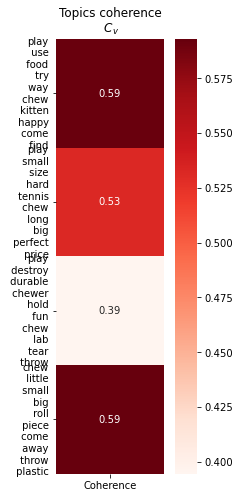

In [47]:
coherence_per_topic = coherence_model_lda.get_coherence_per_topic()
topics_str = [ '\n '.join(t) for t in topics ]
data_topic_score = pd.DataFrame( data=zip(topics_str, coherence_per_topic), columns=['Topic', 'Coherence'] )
data_topic_score = data_topic_score.set_index('Topic')

fig, ax = plt.subplots( figsize=(4, 8) )
ax.set_title("Topics coherence\n $C_v$")
sns.heatmap(data=data_topic_score, annot=True, square=True,
            cmap='Reds', fmt='.2f',
            linecolor='black', ax=ax )
plt.yticks( rotation=0 )
ax.set_xlabel('')
ax.set_ylabel('')
fig.show()

In [48]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.069047 -0.063748       1        1  31.049346
1      0.001270 -0.045680       2        1  28.781721
3      0.053921  0.101340       3        1  20.891439
0     -0.124237  0.008087       4        1  19.277493, topic_info=        Term         Freq        Total Category  logprob  loglift
371  destroy   866.000000   866.000000  Default  30.0000  30.0000
7    durable   442.000000   442.000000  Default  29.0000  29.0000
162    price   314.000000   314.000000  Default  28.0000  28.0000
276     size   759.000000   759.000000  Default  27.0000  27.0000
370     chew  1243.000000  1243.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
236     tear    87.464138   446.285711   Topic4  -5.4287   0.0165
406     long    92.942150   720.895142   Topic4  -5.3680  -0.4023
52    little    87.165737   740.884847   Topic4  -5.4321  -0.4938
108      big    82.323793   742.195892   Topic4  -5.4893  -0.5527
386    large    79.169513   641.811063   Topic4  -5.5284  -0.4465

[356 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2918      2  0.936233     3rd
25        2  0.035670       =
25        3  0.017835       =
25        4  0.945265       =
403       1  0.440081    able
...     ...       ...     ...
558       1  0.592543    yard
558       2  0.175344    yard
558       3  0.169298    yard
558       4  0.066510    yard
1010      4  0.962695  yorkie

[749 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

# Modeling - NMF

In [49]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts2]

topic_nums = list(np.arange(2, 10 + 1, 1))

coherence_scores = []

for num in topic_nums:
    print('num: ', num)
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        normalize=True,
        random_state=1234
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts2,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))
    
print(coherence_scores)

num:  2
num:  3
num:  4
num:  5
num:  6
num:  7
num:  8
num:  9
num:  10
[0.57878, 0.64882, 0.59128, 0.57313, 0.60212, 0.60424, 0.58863, 0.55814, 0.61049]


In [50]:
# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

3


In [51]:
nmf = Nmf(
        corpus=corpus,
        num_topics=best_num_topics,
        id2word=dictionary,
        normalize=True,
        random_state=1234
    )

In [52]:
nmf.print_topics()

[(0,
  '0.050*"chew" + 0.021*"destroy" + 0.014*"throw" + 0.013*"durable" + 0.013*"hard" + 0.012*"tennis" + 0.011*"chewer" + 0.011*"plastic" + 0.010*"hold" + 0.009*"handle"'),
 (1,
  '0.030*"food" + 0.014*"little" + 0.012*"hard" + 0.012*"eat" + 0.011*"use" + 0.009*"find" + 0.008*"way" + 0.008*"hole" + 0.008*"try" + 0.007*"come"'),
 (2,
  '0.053*"play" + 0.027*"size" + 0.026*"small" + 0.022*"large" + 0.017*"big" + 0.010*"hole" + 0.009*"long" + 0.009*"roll" + 0.009*"come" + 0.007*"try"')]

# Modeling - top2vec

In [ ]:
# import tensorflow as tf
# import tensorflow_hub as hub

# """""""""""""""""""""""""""""""""""""""""""""""""""""""""
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
# None
# """""""""""""""""""""""""""""""""""""""""""""""""""""""""
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
# print(physical_devices)
# print(config)

# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


# embeddings = embed([
#     "The quick brown fox jumps over the lazy dog.",
#     "I am a sentence for which I would like to get its embedding"])
  
# print(embeddings)

In [ ]:
for i in [5000, 6000, 7000, 8000, len(interested_dta['reviewText'].tolist())]:
    random.seed(1234)
    print(i)
    rr = random.sample(interested_dta['reviewText'].tolist(), i)
    try: 
        model = Top2Vec(rr, speed="learn", workers=-1, embedding_model='universal-sentence-encoder')
    except: 
        continue

In [ ]:
model

In [ ]:
model.get_num_topics()
model.topic_words

# Modeling - BERTopic

In [22]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP

# Instantiate the vectorizer model
vectorizer_model = CountVectorizer()

# Instantiate the UMAP model
umap_model = UMAP(n_neighbors=15, n_components=5, metric='cosine')

In [23]:
# define extra stopwords for toy data
sw = ['toy',
 'dog',
 'love',
 'cat',
 'ball',
 'great',
 'buy',
 'good',
 'get',
 'time',
 'puppy',
 'like',
 'treat',
 'thing',
 'old',
 'product',
 'day',
 'think',
 'go',
 'favorite',
 'minute',
 'recommend', 'month', 'know', 'year', 'pet', 'work', 'hour'
     ]
STOP_WORDS = list(STOP_WORDS) + sw 

In [26]:
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=STOP_WORDS) #bigram, remove stopwords
docs = interested_dta['reviewText'].tolist()

model = BERTopic(
    vectorizer_model=vectorizer_model,
    language='english', 
    calculate_probabilities=False,
    verbose=True,
    umap_model=umap_model)
topics, probs = model.fit_transform(docs)

Batches:   0%|          | 0/266 [00:00<?, ?it/s]

In [27]:
vectorizer_model

CountVectorizer(ngram_range=(1, 2),
                stop_words=['ours', 'either', 'elsewhere', 'seemed', 'next',
                            'except', 'n‘t', 'here', 'whatever', 'top',
                            'beyond', 'eight', 'ca', 'noone', 'first', 'mine',
                            'hereby', 'nine', 'whereupon', 'whose', 'everyone',
                            'thereupon', 'wherever', 'why', 'somewhere', 'n’t',
                            'such', 'above', 'now', 'ten', ...])

In [28]:
freq = model.get_topic_info()
freq

model.update_topics(docs, vectorizer_model=vectorizer_model) 

In [29]:
freq = model.get_topic_info()
freq

,Topic,Count,Name
0,-1,3260,-1_loves_dogs_toys_balls
1,0,1157,0_cats_food_scratcher_turbo
2,1,463,1_treats_food_kibble_inside
3,2,292,2_chewer_chewed_chew_minutes
4,3,280,3_loves_dogs_play_yard
...,...,...,...
64,63,13,63_quality_quality loves_hopefully friend_look...
65,64,12,64_squeaky_hard squeaky_squeaker_plush
66,65,11,65_roller_holee_holee roller_holee rollers
67,66,11,66_wubba_wubbas_wubbie_plush version


In [30]:
# hierarchical_topics = model.hierarchical_topics(docs)
# model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [31]:
# model.visualize_barchart(n_words = 10, top_n_topics = 12)

In [32]:
model = BERTopic(nr_topics= 'auto',   
    vectorizer_model=vectorizer_model,
    language='english', 
    calculate_probabilities=False,
    verbose=True,
    umap_model=umap_model)

hdbscan_model = HDBSCAN(min_cluster_size=10, 
                        metric='euclidean', 
                        cluster_selection_method='eom', 
                        prediction_data=True, 
                        min_samples=5)
topic_model = BERTopic(hdbscan_model=hdbscan_model, 
                       nr_topics= 'auto')
topics, probs = topic_model.fit_transform(docs)

In [33]:
# Further reduce topics
freq = topic_model.get_topic_info()
freq

,Topic,Count,Name
0,-1,2852,-1_it_and_the_to
1,0,4151,0_the_to_it_and
2,1,198,1_squeaker_squeak_squeaky_these
3,2,103,2_it_noise_sounds_noises
4,3,100,3_price_great_store_product
5,4,96,4_kong_peanut_butter_and
6,5,82,5_smell_smells_it_chemical
7,6,79,6_rope_the_ball_is
8,7,65,7_glow_light_glows_dark
9,8,58,8_works_work_great_worked


In [34]:
topic_model.update_topics(docs, vectorizer_model=vectorizer_model) 
freq = topic_model.get_topic_info()

In [35]:
freq.head()

,Topic,Count,Name
0,-1,2852,-1_loves_dogs_toys_balls
1,0,4151,0_food_balls_loves_treats
2,1,198,1_squeaker_squeak_squeaky_loves
3,2,103,2_noise_sounds_noises_sound
4,3,100,3_price_store_deal_excellent


In [ ]:
topic_model.visualize_barchart(n_words = 10, top_n_topics = 10)

In [ ]:
# [i[0].strip('\"') for i in model.get_topic(9)]

In [ ]:
# topic_keywords = model.get_topic_info()
# topic_keywords

In [ ]:
# cleaned_docs = topic_model._preprocess_text(docs)

In [ ]:
from bertopic import BERTopic
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel


cleaned_docs = topic_model._preprocess_text(docs)
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topics = topic_model.get_topics()
topics.pop(-1, None)
topic_words = [
[word for word, _ in topic_model.get_topic(topic) if word != ""] for topic in topics
]
topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
        for topic in range(len(set(topics))-1)][:10]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                          texts=tokens, 
                          corpus=corpus,
                          dictionary=dictionary, 
                          coherence='c_v')
coherence = coherence_model.get_coherence()


In [ ]:
coherence